In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import sklearn
import os
from matplotlib.pyplot import hist

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

In [4]:
x = pd.read_stata("maindata.dta", convert_categoricals=False)
laws_csv = pd.read_csv("When_Were_Laws.csv")
laws_csv = laws_csv[np.logical_not(np.isnan(laws_csv["FIPS"]))]  # FIPS codes identify states
laws_csv = laws_csv.drop("State_Name", axis=1)  # Dropping as useless
laws_csv = laws_csv.rename({'FIPS': 'stfips'}, axis=1) 

# Merging
merged = pd.merge(laws_csv, x, on='stfips', how='outer')

In [5]:
basic_merged = merged.copy()  # To allow for re-running 

basic_merged = basic_merged[basic_merged["a_age"] <= 25]  # Can be changed later, but for now useful I think

# Dropping states who were treated < 97 (i.e. they always had programs)
# This is following Callaway + Sant'anna, as we cannot meaningfully 
# do any inference using those states. Although we can compare them later as a 
# robustness check, which may be interesting
basic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("always")==False]  

# Making it so that "never-treated" states are treated at T = infinity
basic_merged = basic_merged.replace("never", "1000000") 
basic_merged["Year_Implemented"] = basic_merged["Year_Implemented"].astype(int)  # converting to int

# Indicator for if the individual was treated (i.e. under 19 and in a state who added a law)
basic_merged["treatment"] = basic_merged["under19"] # * basic_merged["year_indic"]

# Generating list of confounders of interest, these are not necessarily optimal. 
list_of_confounders = ["year", "stfips", "fownu18", "faminctm1", "a_maritl", "female" , "fpovcut", "povll"]
list_of_confounders += ["anykids", "disability", "noemp_insured"]


In [6]:
def make_g_model():
  return RandomForestClassifier(n_estimators=100, max_depth=2)

In [7]:
def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int):
    """
    Implements K fold cross-fitting for the model predicting the treatment A. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    """
    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    for train_index, test_index in kf.split(X, A):
      X_train = X.loc[train_index]
      A_train = A.loc[train_index]
      g = make_model()
      g.fit(X_train, A_train)

      # get predictions for split
      predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]

    assert np.isnan(predictions).sum() == 0
    return predictions

In [8]:
#Calculating probability of being treated (under 19) while living in a state that implemented during that year 

def calculate_g(treated_year):
    sub_merged = basic_merged.copy()
    sub_merged = sub_merged[sub_merged["Year_Implemented"] == treated_year]
    sub_merged = sub_merged[sub_merged["year"] == treated_year]
    
    sub_merged = sub_merged.reset_index()
    
    confounders = sub_merged[["year","stfips", "fownu18", "faminctm1", "a_maritl", "female","fpovcut", "povll", "anykids", "disability", "noemp_insured"]]
    treatment = sub_merged['treatment']
    outcome = sub_merged['pubonly']
    g = treatment_k_fold_fit_and_predict(make_g_model, X=confounders, A=treatment, n_splits=10)
    
    return g
    

(array([1.0443047 , 2.24159672, 2.22829348, 1.33697609, 0.95118199,
        0.83810441, 0.1795938 , 0.95783361, 1.48331178, 4.98871674]),
 array([0.13969637, 0.20123516, 0.26277395, 0.32431274, 0.38585152,
        0.44739031, 0.5089291 , 0.57046789, 0.63200668, 0.69354547,
        0.75508426]),
 <a list of 10 Patch objects>)

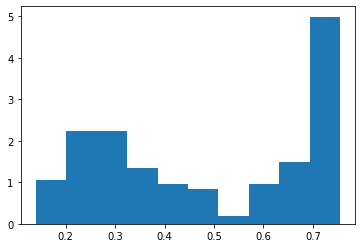

In [9]:
g1 = calculate_g(1997)
hist(g1, density=True)

In [10]:
sub_merged = basic_merged.copy()
sub_merged = sub_merged[sub_merged['year'] == 1997]
sub_merged["year_indic"] = (sub_merged["Year_Implemented"] == 1997)
sub_merged["treatment"] = sub_merged["under19"] * sub_merged["year_indic"]

In [11]:
#during year 1997, probability of both being under 19 and living in a state that passed the law in 1997
sub_merged = sub_merged.reset_index()
    
confounders = sub_merged[["year", 'stfips',"fownu18", "faminctm1", "a_maritl", "female","fpovcut", "povll", "anykids", "disability", "noemp_insured"]]
treatment = sub_merged['treatment']
outcome = sub_merged['pubonly']
g = treatment_k_fold_fit_and_predict(make_g_model, X=confounders, A=treatment, n_splits=10)

(array([ 4.30261162, 11.7066891 , 11.93526534, 13.24845826,  9.64502104,
         8.31390057, 18.37125522,  6.61974725,  1.9809941 ,  0.34958719]),
 array([0.011421  , 0.02298523, 0.03454946, 0.0461137 , 0.05767793,
        0.06924216, 0.08080639, 0.09237063, 0.10393486, 0.11549909,
        0.12706332]),
 <a list of 10 Patch objects>)

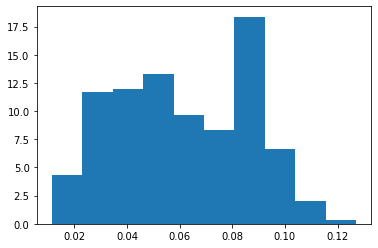

In [12]:
hist(g, density=True)

In [15]:
#running on all data

In [16]:
basic_merged = basic_merged.reset_index()

In [17]:
confounders = basic_merged[["year","stfips", "fownu18", "faminctm1", "a_maritl", "female","fpovcut", "povll", "anykids", "disability", "noemp_insured"]]
treatment = basic_merged['treatment']
outcome = basic_merged['pubonly']
g = treatment_k_fold_fit_and_predict(make_g_model, X=confounders, A=treatment, n_splits=10)
    

(array([0.44753303, 1.85498574, 2.18222458, 0.55172118, 1.99038381,
        1.18543997, 0.20332974, 0.5723369 , 2.1712009 , 5.64147879]),
 array([0.11416017, 0.17368174, 0.2332033 , 0.29272486, 0.35224642,
        0.41176798, 0.47128954, 0.5308111 , 0.59033266, 0.64985422,
        0.70937578]),
 <a list of 10 Patch objects>)

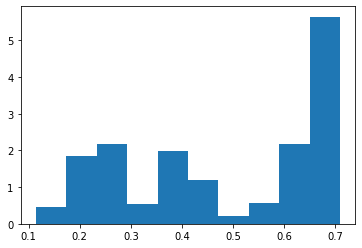

In [18]:
hist(g, density=True)